**Install 🍇 by running:**

```bash
pip install grape -U
```

In [1]:
from grape.datasets.zenodo import (
    GameOfThronesCharactersInteractions
)
graph = GameOfThronesCharactersInteractions()

We get the books one to four with a filter:

In [2]:
first_boooks = graph.filter_from_names(
    edge_type_names_to_remove=["5"],
)

We get the fifth book with a filter

In [3]:
fifth_book = graph.filter_from_names(
    edge_type_names_to_keep=["5"],
)

But we are only interested in interactions
EXCLUSIVELY from the fifth book.

In [4]:
exclusively_fifth_book = (
    fifth_book - first_boooks
)

We need to remove characters that only
appear in the fifth book, as there is no
hope to predict them.

In [5]:
disconnected = first_boooks\
    .get_singleton_node_names()
first_boooks = first_boooks\
    .remove_disconnected_nodes()
exclusively_fifth_book = exclusively_fifth_book\
    .filter_from_names(
        node_names_to_remove=disconnected
    )

We also sample a negative graph to evaluate the performance

In [6]:
negative_graph = first_boooks\
    .sample_negative_graph(
        number_of_negative_samples=exclusively_fifth_book\
            .get_number_of_directed_edges(),
        use_scale_free_distribution=True
    )

*We use scale free distribution for the sampling so to avoid degree biases.*

We computer a First-order LINE embedding

In [7]:
%%time
from grape.embedders import FirstOrderLINEEnsmallen

embedding = FirstOrderLINEEnsmallen(epochs=1000)\
    .fit_transform(first_boooks)

CPU times: user 9.62 s, sys: 45.8 ms, total: 9.66 s
Wall time: 414 ms


We create a simple percepron model, trained on the cosine similarity of the embedding.

In [8]:
from grape.edge_prediction import PerceptronEdgePrediction

model = PerceptronEdgePrediction(
    edge_features=None,
    edge_embeddings=[
        "CosineSimilarity"
    ],
    number_of_edges_per_mini_batch=8
)

We fit the model on the first books graph

In [9]:
model.fit(
    first_boooks,
    node_features=embedding
)

We get the predictions for the fifth book

In [10]:
pred = model.predict_proba(
    exclusively_fifth_book,
    node_features=embedding,
    return_predictions_dataframe=True
).sort_values("predictions")

In [11]:
pred

,predictions,sources,destinations
17,0.011976,Jon Snow,Sansa Stark
11,0.011976,Sansa Stark,Jon Snow
167,0.018791,Theon Greyjoy,Jeyne Poole
87,0.018791,Jeyne Poole,Theon Greyjoy
467,0.019270,Ramsay Snow,Jeyne Poole
...,...,...,...
285,0.956989,Rakharo,Aggo
100,0.957021,Jhogo,Aggo
387,0.957021,Aggo,Jhogo
91,0.957123,Jhiqui,Irri


We get the predictions for non-existent edges

In [12]:
not_pred = model.predict_proba(
    negative_graph,
    node_features=embedding,
    return_predictions_dataframe=True
).sort_values("predictions")

In [13]:
not_pred

,predictions,sources,destinations
335,0.005477,Tywin Lannister,Jarl
1290,0.005477,Jarl,Tywin Lannister
318,0.005544,Tywin Lannister,Jeor Mormont
52,0.005544,Jeor Mormont,Tywin Lannister
243,0.005592,Kevan Lannister,Jon Snow
...,...,...,...
1060,0.911028,Osfryd Kettleblack,Dorcas
477,0.923487,Marq Piper,Walder Frey
588,0.923487,Walder Frey,Marq Piper
794,0.944042,Aggo,Pono


We  plot the predictions

In [14]:
import matplotlib.pyplot as plt

def plot_predictions(pred, not_pred):
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.hist(
        [pred.predictions, not_pred.predictions],
        label=("Non-existing", "Fifth book only"),
        bins=30,
    )
    ax.set_xlabel("Prediction score")
    ax.set_ylabel("Prediction counts")
    ax.set_title("Predictions")
    _ = ax.legend()

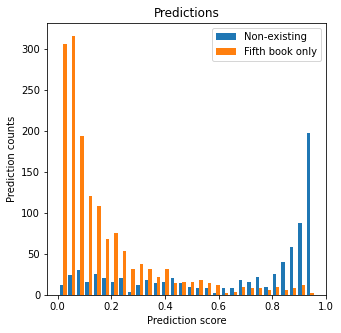

In [15]:
plot_predictions(pred, not_pred)